# 1 - Load Data & Preprocess
do some data exploration here and maybe based on that explain what we're going to do

In [2]:
from pathlib import Path
from os.path import abspath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

In [3]:
home_path = Path(abspath(''))
train_data_path = home_path.joinpath('data/train_2025.csv')
test_data_path = home_path.joinpath('data/test_2025.csv')
test_answers_path = home_path.joinpath('data/answer_key_2025.csv')

In [4]:
X_dataframe = pd.read_csv(train_data_path)
test_X_dataframe = pd.read_csv(test_data_path)
test_y_dataframe = pd.read_csv(test_answers_path)

In [5]:
X_dataframe.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 1993,Gene 1994,Gene 1995,Gene 1996,Gene 1997,Gene 1998,Gene 1999,Gene 2000,Outcome,Id
0,4.0,107.0,135.0,15752.0,459.0,189.0,222.0,2258.0,2992.0,77.0,...,156.0,18368.0,318.0,89.0,307.0,82.0,227.0,302.0,3,3328
1,4.0,96.0,130.0,13704.0,486.0,244.0,298.0,NaN,1874.0,50.0,...,82.0,21033.0,375.0,NaN,426.0,91.0,232.0,116.0,1,2085
2,5.0,139.0,71.0,13866.0,326.0,418.0,402.0,2833.0,1821.0,64.0,...,122.0,13853.0,244.0,114.0,273.0,87.0,219.0,NaN,3,2455
3,3.0,135.0,47.0,14945.0,432.0,239.0,224.0,3020.0,2958.0,69.0,...,50.0,16328.0,289.0,NaN,NaN,98.0,244.0,312.0,3,2457
4,2.0,69.0,48.0,8758.0,337.0,214.0,358.0,NaN,3388.0,80.0,...,119.0,10714.0,557.0,99.0,206.0,107.0,136.0,364.0,1,3641



Total missing values across features: 497869
Missing values per feature (showing non-zero counts):
Gene 1       250
Gene 2       237
Gene 3       266
Gene 4       255
Gene 5       249
            ... 
Gene 1996    239
Gene 1997    253
Gene 1998    259
Gene 1999    252
Gene 2000    236
Length: 2000, dtype: int64

Total infinite values: 0
Total negative values: 0

Class counts:
Outcome
3    1280
2     881
1     730
0     629
Name: count, dtype: int64

Class proportions:
Outcome
3    0.363636
2    0.250284
1    0.207386
0    0.178693
Name: count, dtype: float64

Number of highly correlated feature pairs (r > 0.95): 59
A few example pairs (feature1, feature2, correlation):
('Gene 4', 'Gene 1323', 0.9999999926269247)
('Gene 8', 'Gene 1822', 0.9999994950756063)
('Gene 32', 'Gene 888', 0.9999999662673034)
('Gene 39', 'Gene 84', 0.9999991915915483)
('Gene 39', 'Gene 848', 0.9999996451767204)

Maximum expression value in the data: 51663.0
Minimum expression value in the data: 0.0

Feature with

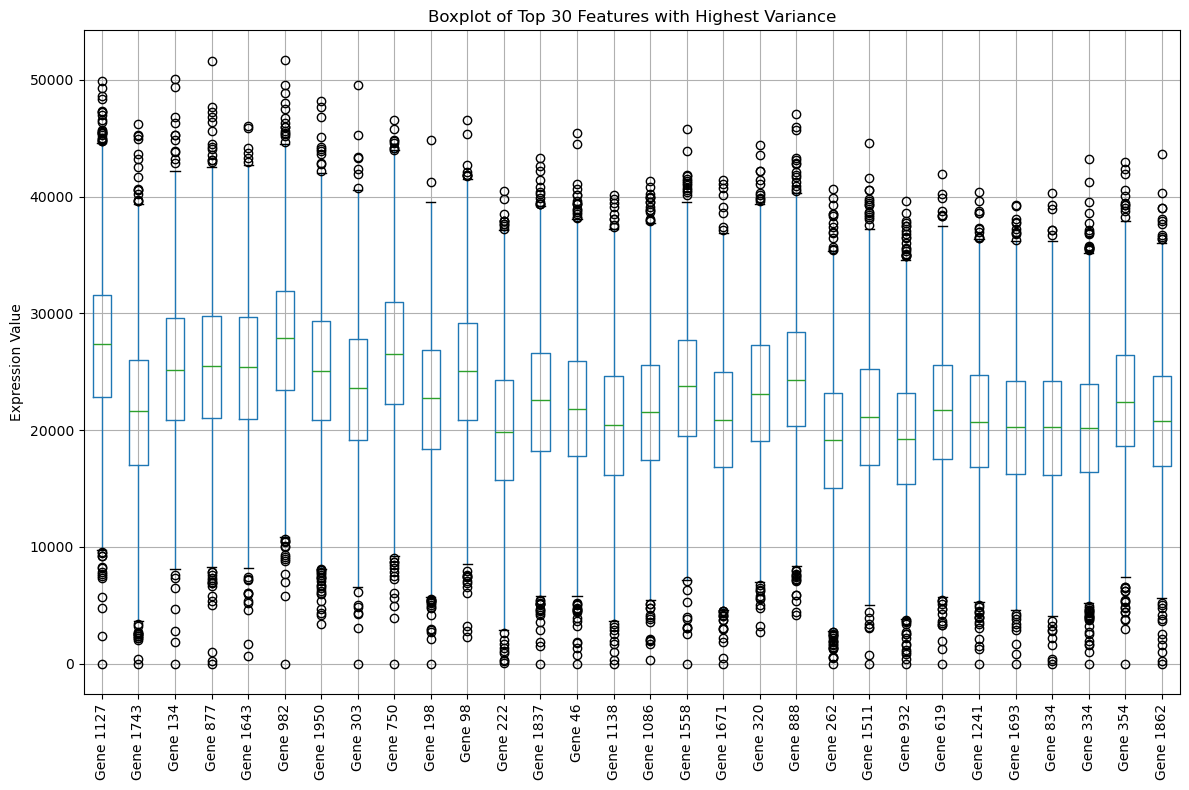

In [6]:
# --- Assume the following dataframes are already loaded:
# X_dataframe (training data with gene expression features and a label column, e.g. "label")
# test_X_dataframe and test_y_dataframe are loaded similarly

# Seperate features and target variable
target_name = 'Outcome'
labels = X_dataframe[target_name]
features = X_dataframe.drop([target_name, 'Id'], axis=1) # DROPPING ID HERE BUT MIGHT BE GOOD TO LEAVE IN

# 1. Count missing data
missing_counts = features.isna().sum()
total_missing = missing_counts.sum()
print("\nTotal missing values across features:", total_missing)
print("Missing values per feature (showing non-zero counts):")
print(missing_counts[missing_counts > 0])

# 2. Check for other strange values
# Here we check for infinite values and negative values.
num_infinite = np.isinf(features.values).sum()
num_negative = (features < 0).sum().sum()
print("\nTotal infinite values:", num_infinite)
print("Total negative values:", num_negative)
# (Depending on your data processing, gene expression data might be expected to be non-negative.)

# 3. Proportion of classes (if labels available)
if labels is not None:
    class_counts = labels.value_counts()
    print("\nClass counts:")
    print(class_counts)
    print("\nClass proportions:")
    print(class_counts / class_counts.sum())

# 4. Check for extremely high correlation between features.
# We define "extremely highly correlated" as absolute Pearson correlation > 0.95.
corr_matrix = features.corr().abs()
threshold = 0.95
high_corr_pairs = []
cols = corr_matrix.columns

# Count only unique pairs (i < j to avoid double counting)
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i, j]))

print("\nNumber of highly correlated feature pairs (r > 0.95):", len(high_corr_pairs))
if len(high_corr_pairs) > 0:
    print("A few example pairs (feature1, feature2, correlation):")
    for pair in high_corr_pairs[:5]:
        print(pair)

# 5. Maximum and minimum values in the features
max_val = features.max().max()
min_val = features.min().min()
print("\nMaximum expression value in the data:", max_val)
print("Minimum expression value in the data:", min_val)

# 6. Feature with the highest variance.
variances = features.var()
top_feature = variances.idxmax()
print("\nFeature with the highest variance:", top_feature)
print("Highest variance value:", variances.max())

# Additionally, demonstrate scikit-learn's VarianceThreshold.
vt = VarianceThreshold(threshold=0)  # threshold 0 selects all non-constant features
vt.fit(features)
# vt.variances_ holds the variances for each feature (in the same order as features.columns)
print("\nFirst five variances using VarianceThreshold:", vt.variances_[:5])

# 7. Boxplot of the top 30 features with highest variance.
# Identify top 30 features ordered by variance
top30_features = variances.sort_values(ascending=False).head(30).index
plt.figure(figsize=(12, 8))
# Boxplot for each selected feature
features[top30_features].boxplot(rot=90)
plt.title("Boxplot of Top 30 Features with Highest Variance")
plt.ylabel("Expression Value")
plt.tight_layout()
plt.show()


## HOW TO IMPROVE DATA EXPLORE
- have all this in formation in the graphs

# 2 - Downsample data

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Assume X is your features and y is your labels
rus = RandomUnderSampler(random_state=42)
X_downSampled, y_downSampled = rus.fit_resample(features, labels)

# Checking:
class_counts = y_downSampled.value_counts()
print("\nClass counts:")
print(class_counts)

c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Class counts:
Outcome
0    629
1    629
2    629
3    629
Name: count, dtype: int64


# Initialize experiments
Initialize model, pipeline, cross validation, and run them

## 3, 4, 5 - Regression

In [66]:
# from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import cross_validate

In [45]:
global_seed = 42

### 3 - Simple imputation, Standard Scaling, and non-regularized Logistic regression

Make a Pipeline that combines three steps: 
* imputing missing data (removing np.nan) by replacing them with the mean value (SimpleImputer) ✅
* scaling the data to have 0 mean and unit variance (StandardScaler) ✅
* predicting the class using unregularized logistic regression (sklearn.linear_model.LogisticRegression) ✅

Now
* split the training data into 20% validation and 80% train data. ✅
* Fit the Pipeline on the train data and test on the validation data. ✅

In your notebook file:
* report the ROC AUC one-versus-rest and macro F1 score on the training and validation data. ✅
* Read up on these here (1, 2) so you know what they are, and write what they do in your own words in the notebook. ✅
* describe why you can’t directly impute and/or scale on all the training data and only then split into train and validation sets if you want an accurate estimate of your generalisation performance ❌

In [46]:
train_data_3, val_data_3, train_lables_3, val_lables_3 = train_test_split(X_downSampled, y_downSampled, train_size=0.8, random_state=global_seed)

imputer_3 = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler_3 = StandardScaler()
log_regressor_3 = LogisticRegression(penalty=None)

model_3 = make_pipeline(imputer_3, scaler_3, log_regressor_3)

# train model
start = time.time()
model_3.fit(train_data_3, train_lables_3)
print(f"Fitting took {time.time() - start:0.03} seconds")

# validate model
accuracy_3 = model_3.score(val_data_3, val_lables_3)
print(f"Accuracy of model on validation dataset: {accuracy_3:0.03}")

Fitting took 0.505 seconds
Accuracy of model on validation dataset: 0.631


**The reason we can't can’t directly impute and/or scale on all the training data and only then split into train and validation sets if we want an accurate estimate of your generalisation performance**

In [64]:
# Training
# We use the predict_proba and not predict, since for ROC (and AUC) we need to predict for different thresholds
train_3_OvR_AUC = roc_auc_score(train_lables_3, model_3.predict_proba(train_data_3), multi_class='ovr')
train_3_macro_F1 = f1_score(train_lables_3, model_3.predict(train_data_3), average='macro')
print(f"Our model's scores on the training dataset:")
print(f"OvR AUC score: {train_3_OvR_AUC:0.03}\nMacro F1 score: {train_3_macro_F1:0.03}\n")

# Validation
val_3_OvR_AUC = roc_auc_score(val_lables_3, model_3.predict_proba(val_data_3), multi_class='ovr')
val_3_macro_F1 = f1_score(val_lables_3, model_3.predict(val_data_3), average='macro')
print(f"Our model's scores on the validation dataset:")
print(f"OvR AUC score: {val_3_OvR_AUC:0.03}\nMacro F1 score: {val_3_macro_F1:0.03}\n")

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0

Our model's scores on the validation dataset:
OvR AUC score: 0.866
Macro F1 score: 0.63



**What are ROC AUC one-versus-rest and macro F1 score?**

_ROC AUC one-versus-rest (OvR):_

OvR is A method to used binary-class-metrics to evaluate multiclass models. In this method, we iterate on our classification output n times, each time taking the n-th class as "Positive" and all other classes as "Negative". This enable us to treat each of these iterations as a binary classification. We then get the results of all metrics on each of these iterations, and average them to get the final OvR model scores.

For ROC AUC one-versus-rest we plot an ROC curve and calculate the AUC for every iteration of OvR, and return the final average score of AUC.

_macro F1 score:_

F1 is a metric that combines both precision and recall. For multi-class classification, we calculate F1 score using OvR. To combine the scores into one final score, there are different methods, one of which is Macro Average.

With Macro Average, we take the unweighted mean of the F1 scores per classs (OvR). This gives a similar weight to all classes, even for an imbalanced data.

### 4 - KNN imputation, Standard Scaling, and non-regularized Logistic regression

Again, make a Pipeline that combines three steps:
* scaling each value to 0 mean and unit variance ✅
* using a KNN imputer to impute missing data (removing np.nan). Set n_neighbors to 3 and weights to ‘distance’. Make sure you understand what this does. ✅
* Using a logistic regression without regularisation to predict the class. ✅
* Train on the same 80% split ✅
* report the performance on the validation data (F1 macro; ROC AUC OvR). ✅
* Then finally train on all your training data, and predict on the test set. ❌❌❌❌ (**Dieter removed this**)
* In your notebook, write down why the order of imputation and scaling is now different compared to step 3, and what would happen if you do it the other way around. ✅


In [62]:
imputer_4 = KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')
scaler_4 = StandardScaler()
log_regressor_4 = LogisticRegression(penalty=None)

model_4 = make_pipeline(scaler_4, imputer_4, log_regressor_4)

# train model
start = time.time()
model_4.fit(train_data_3, train_lables_3)
print(f"Fitting took {time.time() - start:0.03} seconds")

# validate model
accuracy_4 = model_4.score(val_data_3, val_lables_3)
print(f"Accuracy of model on validation dataset: {accuracy_4:0.03}")

Fitting took 1.93e+02 seconds
Accuracy of model on validation dataset: 0.643


In [ ]:
# Training
start = time.time()
# We use the predict_proba and not predict, since for ROC (and AUC) we need to predict for different thresholds
train_4_OvR_AUC = roc_auc_score(train_lables_3, model_4.predict_proba(train_data_3), multi_class='ovr')
train_4_macro_F1 = f1_score(train_lables_3, model_4.predict(train_data_3), average='macro')
print(f"Our model's scores on the training dataset:")
print(f"OvR AUC score: {train_4_OvR_AUC:0.03}\nMacro F1 score: {train_4_macro_F1:0.03}")
print(f"Getting score took {time.time() - start:0.03} seconds\n")

# Validation
start = time.time()
val_4_OvR_AUC = roc_auc_score(val_lables_3, model_4.predict_proba(val_data_3), multi_class='ovr')
val_4_macro_F1 = f1_score(val_lables_3, model_4.predict(val_data_3), average='macro')
print(f"Our model's scores on the validation dataset:")
print(f"OvR AUC score: {val_4_OvR_AUC:0.03}\nMacro F1 score: {val_4_macro_F1:0.03}\n")
print(f"Getting score took {time.time() - start:0.03} seconds")

Our model's scores on the training dataset:
OvR AUC score: 1.0
Macro F1 score: 1.0

Getting score took 3.23e+02 seconds
Our model's scores on the validation dataset:
OvR AUC score: 0.877
Macro F1 score: 0.642

Getting score took 71.8 seconds


**Why the order of imputation and scaling is now different compared to step 3, and what would happen if we do it the other way around?**

The simple imputer we used in model 3 only uses the mean to impute the missing values.

In contrast, with KNN imputation we search of the n most similar rows to the row with the missing value. Then, it calculate the average (if weight='distance' then this is a weighted average where the weights are the inverse of the distance from our row to this neighbor), and assigns this as the missing value.

If the data is not scaled, then features with a larger range of values would have less effect on the neighbors chosen for KNN imputation than features with a smaller range. Less effect because we use weight that are the inverse of the distance, and a larger range of values would then on average give smaller weights.Therefore it's important to first scale the data.

If we first impute using KNN and only then scale, then some features will dominante over other in the imputation.

### 5 - Simple imputation, and L2 regularized Logistic regression - with cross validation

Regularise using an L2 penalty with a C of one. Note that C is 1/λ. ✅

We will also use cross-validation now, as we know that this gives a better estimate of generalisation performance and uses training data more efficiently.

Make a new Pipeline that:
* uses the SimpleImputer again (KNN is slow) ✅
* uses L2-regularised logistic regression for classification ✅

For training the model:
* use 10-fold cross-validation rather than a single split. Use sklearn.model_selection.cross_validate ✅
* look at F1 macro and ROC AUC OvR averaged over the folds. ❌

Finally
* Report how much average cross-validation performance with regularisation included improves over unregularized logistic regression. ❌

In [ ]:
# X_downSampled, y_downSampled

imputer_5 = SimpleImputer(missing_values=np.nan, strategy='mean')
# scaler_3 = StandardScaler() #NOTE - should we use scaling here?
log_regressor_5 = LogisticRegression(penalty='l2', C=1)

model_5 = make_pipeline(imputer_5, log_regressor_5)

# train model
start = time.time()
cv_result = cross_validate(model_5, X_downSampled, y_downSampled, cv=10, scoring=['f1_macro', 'roc_auc'])
#scoring=['f1_macro', 'roc_auc'] #TODO --> Make this work
print(f"Fitting took {time.time() - start:0.03} seconds")


# validate model
# accuracy_5 = model_3.score(val_data_3, val_lables_3)
# print(f"Accuracy of model on validation dataset: {accuracy_3:0.03}")

c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
  File "c:\Users\samar\miniconda3\envs\BMLB2025\lib\site-packages\sklea

KeyboardInterrupt: 

In [ ]:
cv_result

{'fit_time': array([2.60027242, 2.54206276, 2.00318074, 2.40474892, 2.51690817,
        2.31685829, 2.63170409, 2.37440538, 2.22479033, 2.83610797]),
 'score_time': array([0.09250736, 0.10429478, 0.11970568, 0.09808755, 0.11000848,
        0.09774971, 0.13964367, 0.093189  , 0.14186764, 0.15181112]),
 'test_score': array([0.68650794, 0.69444444, 0.71825397, 0.71428571, 0.69047619,
        0.73015873, 0.66932271, 0.72908367, 0.72908367, 0.76494024])}

# Results
analyze results

# Ideas:

- Plot prediction against Y to get a quick high level  view of the performance
- Consider Halving gridsearch or do randomized search to decrease computation time:
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-heatmap-py
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
- Plot computation time for experiment
- Quantile transform to get rid of outliers
    - Effect of transforms to get a better result. Maybe brute force it?
- plot_output(scaler=scaler) # to get a easy visualisation of what the scaler is doing